In [ ]:
## The efficient multi-head attention module from the ESRT paper
import torch
import torch.nn as nn
import math

class EfficientMultiHeadAttention(nn.Module):
    """
    Implements the Efficient Multi-Head Attention (EMHA) from the ESRT paper.
    It splits the sequence into segments to compute local attention.
    """
    def __init__(self, dim, num_heads, split_factor=4, dropout=0.0):
        super(EfficientMultiHeadAttention, self).__init__()
        assert dim % 2 == 0, "Dimension must be even for reduction"
        self.dim = dim
        self.num_heads = num_heads
        self.split_factor = split_factor  # This is 's' in the paper
        self.head_dim = (dim // 2) // num_heads # dim is reduced by half
        self.scale = self.head_dim ** -0.5

        # 1. Reduction Layer: Halves the channel dimension
        self.reduction = nn.Linear(dim, dim // 2)

        # 2. Linear projection to Q, K, V
        self.to_qkv = nn.Linear(dim // 2, (dim // 2) * 3, bias=False)

        # 3. Expansion Layer: Recovers the original channel dimension
        self.expansion = nn.Linear(dim // 2, dim)

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        # 1. Apply Reduction
        x_reduced = self.reduction(x) # (B, N, C/2)

        # 2. Get Q, K, V
        # (B, N, C/2 * 3) -> 3 tensors of (B, N, C/2)
        qkv = self.to_qkv(x_reduced).chunk(3, dim=-1)

        # Reshape for multi-head: (B, N, C/2) -> (B, num_heads, N, head_dim)
        q, k, v = map(lambda t: t.reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2), qkv)

        # 3. Feature Split (FS) Module
        # Check if N is divisible by the split_factor
        if N % self.split_factor != 0:
            raise ValueError(f"Sequence length {N} is not divisible by split_factor {self.split_factor}")

        # Split along the sequence (N) dimension
        q_splits = q.chunk(self.split_factor, dim=2) # 's' tensors of (B, num_heads, N/s, head_dim)
        k_splits = k.chunk(self.split_factor, dim=2)
        v_splits = v.chunk(self.split_factor, dim=2)

        out_splits = []
        # 4. Calculate attention for each local segment
        for q_i, k_i, v_i in zip(q_splits, k_splits, v_splits):
            # Scaled Dot-Product Attention for the segment
            # (B, num_heads, N/s, head_dim) @ (B, num_heads, head_dim, N/s) -> (B, num_heads, N/s, N/s)
            attn_scores = (q_i @ k_i.transpose(-1, -2)) * self.scale
            attn_probs = self.softmax(attn_scores)
            attn_probs = self.dropout(attn_probs)

            # (B, num_heads, N/s, N/s) @ (B, num_heads, N/s, head_dim) -> (B, num_heads, N/s, head_dim)
            out_i = attn_probs @ v_i
            out_splits.append(out_i)

        # 5. Concatenate the outputs back together
        out = torch.cat(out_splits, dim=2) # (B, num_heads, N, head_dim)

        # Reshape back to (B, N, C/2)
        out = out.transpose(1, 2).reshape(B, N, self.dim // 2)

        # 6. Apply Expansion layer
        out = self.expansion(out) # (B, N, C)
        return out

In [ ]:
## The main Efficient Transformer block
class EfficientTransformerBlock(nn.Module):
    """
    The main Efficient Transformer (ET) block from the ESRT paper.
    Uses pre-normalization (Norm -> Module -> Residual)
    """
    def __init__(self, dim, num_heads, split_factor, mlp_ratio=4., dropout=0.0):
        super(EfficientTransformerBlock, self).__init__()

        # 1. Efficient Multi-Head Attention
        self.norm1 = nn.LayerNorm(dim)
        self.emha = EfficientMultiHeadAttention(
            dim=dim,
            num_heads=num_heads,
            split_factor=split_factor,
            dropout=dropout
        )

        # 2. Feed-Forward Network (MLP)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # EMHA branch
        x = x + self.emha(self.norm1(x))
        # MLP branch
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
## Full model - using bicubic upsampling
import torch
import torch.nn as nn
import torch.nn.functional as F # Import the functional module
import math

class ResidualTransformerBlock(nn.Module):
    """A container for a stack of ET blocks with a final conv and residual"""
    def __init__(self, dim, num_heads, split_factor, num_blocks):
        super(ResidualTransformerBlock, self).__init__()

        self.blocks = nn.Sequential(
            *[EfficientTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                split_factor=split_factor
              ) for _ in range(num_blocks)]
        )
        self.conv = nn.Conv2d(dim, dim, 3, 1, 1)

    def forward(self, x):
        # Input x is (B, N, C)
        B, N, C = x.shape
        # We need (B, C, H, W) for conv, assuming N = H*W
        H = W = int(math.sqrt(N))

        x_tf_out = self.blocks(x) # (B, N, C)

        # Reshape for conv
        x_tf_out_2d = x_tf_out.transpose(1, 2).reshape(B, C, H, W)
        x_conv_out_2d = self.conv(x_tf_out_2d)

        # Add residual from original input (before blocks)
        # Need to reshape the original input for the residual connection
        x_2d = x.transpose(1, 2).reshape(B, C, H, W)

        # Add residual and reshape back to (B, N, C)
        output_2d = x_2d + x_conv_out_2d
        output_seq = output_2d.flatten(2).transpose(1, 2) # (B, N, C)

        return output_seq


class HybridSRModelBicubic(nn.Module):
    """
    Our hybrid model, now using EfficientTransformerBlocks (ETs)
    and ViT-style patch embedding.
    """
    def __init__(self, in_channels=3, out_channels=3, scale=4,
                 embed_dim=64, patch_size=4, num_heads=4,
                 num_rstb=4, num_tf_blocks=6, split_factor=4):
        super(HybridSRModelBicubic, self).__init__()

        self.scale = scale

        # 1. Patch Embedding (ViT-style)
        self.patch_embed = nn.Conv2d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

        # 2. Deep Feature Extraction (using ET blocks)
        self.transformer_backbone = nn.Sequential(
            *[ResidualTransformerBlock(
                dim=embed_dim,
                num_heads=num_heads,
                split_factor=split_factor,
                num_blocks=num_tf_blocks
              ) for _ in range(num_rstb)]
        )

        # 3. Upsampling for the transformer branch (ESPCN-style Sub-pixel layer)
        # This upsamples the learned features to the high-resolution space
        # Achieves a total upsampling of scale * patch_size from patch resolution
        upsampling_factor = self.scale * patch_size
        self.upsample_transformer = nn.Sequential(
            nn.Conv2d(embed_dim, out_channels * (upsampling_factor**2), 3, 1, 1),
            nn.PixelShuffle(upsampling_factor)
        )


        # 4. Final convolution to combine upsampled base and learned residual
        self.final_conv = nn.Conv2d(out_channels * 2, out_channels, 3, 1, 1)


    def forward(self, x):
        # Bicubic upsample for the residual connection
        base = F.interpolate(x, scale_factor=self.scale, mode='bicubic', align_corners=False)

        # 1. Embed Patches
        x_embed = self.patch_embed(x) # (B, C, H_p, W_p)

        # Reshape for Transformer: (B, C, H_p, W_p) -> (B, N, C)
        B, C, H, W = x_embed.shape
        x_seq = x_embed.flatten(2).transpose(1, 2) # (B, H_p*W_p, C)

        # 2. Process with Transformer Backbone
        # The output of the transformer backbone is (B, N, C)
        x_tf_out_seq = self.transformer_backbone(x_seq)

        # Reshape back to (B, C, H_p, W_p) for upsampling
        x_tf_out_2d = x_tf_out_seq.transpose(1, 2).reshape(B, C, H, W)

        # 3. Upsample transformer output to High-Resolution
        x_tf_upsampled = self.upsample_transformer(x_tf_out_2d) # (B, 3, H_hr, W_hr)

        # Concatenate the upsampled base and the upsampled transformer output
        combined = torch.cat((base, x_tf_upsampled), dim=1) # (B, 6, H_hr, W_hr)


        # 4. Final convolution to combine
        out = self.final_conv(combined) # (B, 3, H_hr, W_hr)

        return out

# --- Example Usage ---
# Must use a patch_size that is divisible by the split_factor
# The paper uses patch size 48x48, split_factor 4
# Let's assume an input of 64x64, patch_size=4 -> 16x16=256 patches
# 256 is divisible by split_factor=4
model = HybridSRModelBicubic(
    scale=2,
    embed_dim=64,
    patch_size=4,
    num_heads=4,
    num_rstb=2,
    num_tf_blocks=3,
    split_factor=4 # 's' from the paper
)

lr_image = torch.randn(1, 3, 64, 64)
hr_output = model(lr_image)

print(f"Input shape: {lr_image.shape}")
print(f"Output shape: {hr_output.shape}")

Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 128, 128])


In [5]:
### Updated Final model with pixelshuffle upsampling

import torch
import torch.nn as nn
import torch.nn.functional as F # Import the functional module
import math

class ResidualTransformerBlock(nn.Module):
    """A container for a stack of ET blocks with a final conv and residual"""
    def __init__(self, dim, num_heads, split_factor, num_blocks):
        super(ResidualTransformerBlock, self).__init__()

        self.blocks = nn.Sequential(
            *[EfficientTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                split_factor=split_factor
              ) for _ in range(num_blocks)]
        )
        self.conv = nn.Conv2d(dim, dim, 3, 1, 1)

    def forward(self, x):
        # Input x is (B, N, C)
        B, N, C = x.shape
        # We need (B, C, H, W) for conv, assuming N = H*W
        H = W = int(math.sqrt(N))

        x_tf_out = self.blocks(x) # (B, N, C)

        # Reshape for conv
        x_tf_out_2d = x_tf_out.transpose(1, 2).reshape(B, C, H, W)
        x_conv_out_2d = self.conv(x_tf_out_2d)

        # Add residual from original input (before blocks)
        # Need to reshape the original input for the residual connection
        x_2d = x.transpose(1, 2).reshape(B, C, H, W)

        # Add residual and reshape back to (B, N, C)
        output_2d = x_2d + x_conv_out_2d
        output_seq = output_2d.flatten(2).transpose(1, 2) # (B, N, C)

        return output_seq


class HybridSRModel(nn.Module):
    """
    Our hybrid model, now using EfficientTransformerBlocks (ETs)
    and ViT-style patch embedding.
    """
    def __init__(self, in_channels=3, out_channels=3, scale=4,
                 embed_dim=64, patch_size=4, num_heads=4,
                 num_rstb=4, num_tf_blocks=6, split_factor=4):
        super(HybridSRModel, self).__init__()

        self.scale = scale

        ## Model Components ##
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        # self.upsampling_factor = self.scale * self.patch_size # This is no longer needed to define base_upsampler

        # 1. Patch Embedding (ViT-style)
        self.patch_embed = nn.Conv2d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

        # 2. Deep Feature Extraction (using ET blocks)
        self.transformer_backbone = nn.Sequential(
            *[ResidualTransformerBlock(
                dim=embed_dim,
                num_heads=num_heads,
                split_factor=split_factor,
                num_blocks=num_tf_blocks
              ) for _ in range(num_rstb)]
        )

        # 3. Upsampling for the transformer branch (ESPCN-style Sub-pixel layer)
        # This upsamples the learned features to the high-resolution space
        # Achieves a total upsampling of scale * patch_size from patch resolution
        # The `upsampling_factor` here (scale * patch_size) correctly compensates for the patch_embed downsampling
        upsampling_factor_transformer = self.scale * patch_size
        self.upsample_transformer = nn.Sequential(
            nn.Conv2d(embed_dim, out_channels * (upsampling_factor_transformer**2), 3, 1, 1),
            nn.PixelShuffle(upsampling_factor_transformer)
        )

        # Pixel shuffle upsample for the base
        # This should upsample by 'scale' to match the final HR resolution (H_lr * scale, W_lr * scale)
        self.base_upsampler = nn.Sequential(
            nn.Conv2d(in_channels, out_channels * (self.scale**2), 3, 1, 1),
            nn.PixelShuffle(self.scale)
        )

        # 4. Final convolution to combine upsampled base and learned residual
        self.final_conv = nn.Conv2d(out_channels * 2, out_channels, 3, 1, 1)


    def forward(self, x):
        # Apply the pre-defined base upsampler to the input x to get a tensor
        base_upsampled_tensor = self.base_upsampler(x) # (B, out_channels, H_lr * scale, W_lr * scale)

        # 1. Embed Patches
        x_embed = self.patch_embed(x) # (B, C_embed, H_lr/patch_size, W_lr/patch_size)

        # Reshape for Transformer: (B, C_embed, H_p, W_p) -> (B, N, C_embed)
        B, C_embed, H_p, W_p = x_embed.shape
        x_seq = x_embed.flatten(2).transpose(1, 2) # (B, H_p*W_p, C_embed)

        # 2. Process with Transformer Backbone
        # The output of the transformer backbone is (B, N, C_embed)
        x_tf_out_seq = self.transformer_backbone(x_seq)

        # Reshape back to (B, C_embed, H_p, W_p) for upsampling
        x_tf_out_2d = x_tf_out_seq.transpose(1, 2).reshape(B, C_embed, H_p, W_p)

        # 3. Upsample transformer output to High-Resolution
        # (B, out_channels, H_p * (scale*patch_size), W_p * (scale*patch_size)) which simplifies to (B, out_channels, H_lr * scale, W_lr * scale)
        x_tf_upsampled = self.upsample_transformer(x_tf_out_2d)

        # Concatenate the upsampled base and the upsampled transformer output
        combined = torch.cat((base_upsampled_tensor, x_tf_upsampled), dim=1) # (B, out_channels * 2, H_hr, W_hr)

        # 4. Final convolution to combine
        out = self.final_conv(combined) # (B, out_channels, H_hr, W_hr)

        return out

# --- Example Usage --- (Removed for now to allow re-execution)
# The example usage will be run in the next step to confirm the fix.
# Must use a patch_size that is divisible by the split_factor
# The paper uses patch size 48x48, split_factor 4
# Let's assume an input of 64x64, patch_size=4 -> 16x16=256 patches
# 256 is divisible by split_factor=4
model = HybridSRModel(
    scale=2,
    embed_dim=64,
    patch_size=4,
    num_heads=4,
    num_rstb=8,
    num_tf_blocks=8,
    split_factor=4 # 's' from the paper
)

lr_image = torch.randn(1, 3, 64, 64)
hr_output = model(lr_image)

print(f"Input shape: {lr_image.shape}")
print(f"Output shape: {hr_output.shape}")

Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 128, 128])


## Dataset preparation



In [ ]:
## Load and preprocess the Div2k dataset for super-resolution training, creating low-resolution and high-resolution pairs.

import os
from PIL import Image
import torchvision.transforms as transforms
import torch

# TODO: Replace with the actual path to your Set5 folder in Google Drive
# set5_path = '/content/drive/My Drive/Computer-Vision-Data/Set5/original'
# set5_path = './Data/Set5/original'  # Update this path accordingly
div2k_path = './Data/DIV2K_valid_HR'  # Update this path accordingly
# div2k_path = './Data/DIV2K_valid_LR_bicubic/X4'  # Update this path accordingly

# Define transformations
# High-resolution image (HR)
hr_transform_to_tensor = transforms.ToTensor()

# Low-resolution image (LR)
# We will resize the HR image to create the LR image
# The size will be HR size / scale
scale_factor = 2 # Change the scale factor as needed
patch_size = 4 # Define patch_size here
split_factor = 4 # Define split_factor here

# Define padding transformation for LR images
# Pad to a square size divisible by patch_size
def get_square_padding_size(image_size, patch_size):
    width, height = image_size
    max_dim = max(width, height)
    # Pad max_dim to be divisible by patch_size
    padded_max_dim = (max_dim + patch_size - 1) // patch_size * patch_size
    pad_width = padded_max_dim - width
    pad_height = padded_max_dim - height
    # Pad format: (left, top, right, bottom) - pad equally on right and bottom
    pad_left = pad_top = 0
    pad_right = pad_width
    pad_bottom = pad_height
    return (pad_left, pad_top, pad_right, pad_bottom), padded_max_dim

# Define padding transformation for HR images
# Pad to a square size that is scale times the padded LR size
def get_hr_padding_size(hr_image_size, padded_lr_size, scale_factor):
    hr_width, hr_height = hr_image_size
    target_hr_size = padded_lr_size * scale_factor
    pad_width = target_hr_size - hr_width
    pad_height = target_hr_size - hr_height
    # Pad format: (left, top, right, bottom) - pad equally on right and bottom
    pad_left = pad_top = 0
    pad_right = pad_width
    pad_bottom = pad_height
    return (pad_left, pad_top, pad_right, pad_bottom)


def load_data(set5_dir, scale_factor, patch_size):
    image_files = [os.path.join(set5_dir, f) for f in os.listdir(set5_dir) if f.endswith(('.png', '.jpg', '.bmp'))]
    hr_images = []
    lr_images = []

    # Define the ToTensor transform once
    to_tensor = transforms.ToTensor()


    for img_path in image_files:
        hr_img = Image.open(img_path).convert('RGB')

        # Calculate the target size for the LR image
        hr_width, hr_height = hr_img.size
        lr_width, lr_height = hr_width // scale_factor, hr_height // scale_factor
        lr_size = (lr_height, lr_width) # Resize expects (height, width) tuple

        # Apply resizing for the LR image by creating Resize transform here
        resize_transform = transforms.Resize(size=lr_size, interpolation=transforms.InterpolationMode.BICUBIC)
        lr_img = resize_transform(hr_img)

        # Apply padding to the LR image to make it square and divisible by patch_size
        lr_padding, padded_lr_size = get_square_padding_size(lr_img.size, patch_size)
        lr_img_padded = transforms.Pad(lr_padding)(lr_img)

        # Apply ToTensor for the padded LR image
        lr_images.append(to_tensor(lr_img_padded))

        # Apply padding to the HR image to match the expected model output size
        hr_padding = get_hr_padding_size(hr_img.size, padded_lr_size, scale_factor)
        hr_img_padded = transforms.Pad(hr_padding)(hr_img)

        # Apply ToTensor for the padded HR image
        hr_images.append(to_tensor(hr_img_padded))


    return lr_images, hr_images

# Load the data
try:
    # Need to pass patch_size to load_set5_data
    # Use the defined patch_size
    # lr_images_set5, hr_images_set5 = load_set5_data(set5_path, scale_factor, patch_size)
    lr_images, hr_images = load_data(div2k_path, scale_factor, patch_size)
    print(f"Loaded {len(lr_images)} LR images and {len(hr_images)} HR images from div2k.")
    if len(lr_images) > 0:
        print(f"Example padded LR image shape: {lr_images[0].shape}")
        print(f"Example padded HR image shape: {hr_images[0].shape}")

except FileNotFoundError:
    print(f"Error: directory not found at {div2k_path}. Please update the path variable.")
except Exception as e:
    print(f"An error occurred: {e}")

Loaded 100 LR images and 100 HR images from Set5.
Example padded LR image shape: torch.Size([3, 1020, 1020])
Example padded HR image shape: torch.Size([3, 2040, 2040])


In [7]:
## Modified training loop
import torch.optim as optim

# Instantiate the model
model = HybridSRModel(
    scale=scale_factor, # Use the defined scale_factor
    embed_dim=64,
    patch_size= patch_size,
    num_heads=4,
    num_rstb=8, # You can adjust these parameters
    num_tf_blocks=6,
    split_factor= split_factor
)

# Define the loss function (L1 loss is common for SR)
criterion = nn.L1Loss()

# Re-instantiate the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.9, 0.999))

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

print("Optimizer and StepLR scheduler re-instantiated successfully.")

Optimizer and StepLR scheduler re-instantiated successfully.


## Define Training functions and loop

In [9]:
## Run Training Loop with New Function and Scheduler
import random
import torch

def train_one_epoch_augmented(model, lr_images, hr_images, criterion, optimizer, device, scale_factor, lr_crop_size, num_patches_per_image=16):
    model.train() # Set the model to training mode
    running_loss = 0.0
    total_actual_patches_processed_in_epoch = 0 # Initialize a counter for actual patches

    hr_crop_size = lr_crop_size * scale_factor

    # Iterate over the dataset
    for i in range(len(lr_images)):
        # Original full image (C, H, W)
        full_lr_img = lr_images[i]
        full_hr_img = hr_images[i]

        lr_patches_batch = []
        hr_patches_batch = []

        for _ in range(num_patches_per_image):
            # 3.c.i. Randomly select top-left corner for LR crop
            # Ensure the crop fits within the image dimensions
            # lr_image.shape is (C, H, W)
            max_x_lr = full_lr_img.shape[2] - lr_crop_size
            max_y_lr = full_lr_img.shape[1] - lr_crop_size

            if max_x_lr < 0 or max_y_lr < 0:
                # Skip if image is too small for crop, or handle with padding if desired
                # For now, let's just skip this patch if a crop isn't possible
                continue

            x_lr = random.randint(0, max_x_lr)
            y_lr = random.randint(0, max_y_lr)

            # 3.c.ii. Extract LR and HR patches
            lr_patch = full_lr_img[:, y_lr : y_lr + lr_crop_size, x_lr : x_lr + lr_crop_size]

            x_hr = x_lr * scale_factor
            y_hr = y_lr * scale_factor
            hr_patch = full_hr_img[:, y_hr : y_hr + hr_crop_size, x_hr : x_hr + hr_crop_size]

            # 3.c.iii. Horizontal Flipping
            if random.random() < 0.5:
                lr_patch = torch.flip(lr_patch, [-1]) # Flip along width (last dimension)
                hr_patch = torch.flip(hr_patch, [-1])

            # 3.c.iv. 90-degree Rotation
            rotation_choice = random.random()
            if rotation_choice < 0.25: # 0 degrees (no rotation)
                k = 0
            elif rotation_choice < 0.50: # 90 degrees
                k = 1
            elif rotation_choice < 0.75: # 180 degrees
                k = 2
            else: # 270 degrees
                k = 3

            if k > 0:
                # Rotate along height and width (dimensions 1 and 2 for C, H, W)
                lr_patch = torch.rot90(lr_patch, k=k, dims=[1, 2])
                hr_patch = torch.rot90(hr_patch, k=k, dims=[1, 2])

            # 3.c.v. Add to batch lists
            lr_patches_batch.append(lr_patch)
            hr_patches_batch.append(hr_patch)

        # Skip if no patches were extracted (e.g., image too small)
        if not lr_patches_batch:
            continue

        # 3.d. Stack patches into mini-batch tensors
        lr_batch = torch.stack(lr_patches_batch)
        hr_batch = torch.stack(hr_patches_batch)

        # Increment the counter for total processed patches
        total_actual_patches_processed_in_epoch += len(lr_patches_batch)

        # 3.e. Move these mini-batch tensors to the specified device
        lr_batch = lr_batch.to(device)
        hr_batch = hr_batch.to(device)

        # 3.f. Zero the parameter gradients
        optimizer.zero_grad()

        # 3.g. Forward pass
        outputs = model(lr_batch)

        # 3.h. Calculate the loss
        loss = criterion(outputs, hr_batch)

        # 3.i. Backward pass and optimize
        loss.backward()
        optimizer.step()

        # 3.j. Accumulate the loss (multiplied by num_patches_per_image for average)
        running_loss += loss.item() * len(lr_patches_batch) # Use actual number of patches

    # 4. Calculate average epoch loss
    if total_actual_patches_processed_in_epoch > 0:
        epoch_loss = running_loss / total_actual_patches_processed_in_epoch
    else:
        epoch_loss = 0.0 # No patches processed in this epoch

    return epoch_loss

print("New training loop function 'train_one_epoch_augmented' defined with data augmentation.")

New training loop function 'train_one_epoch_augmented' defined with data augmentation.


In [10]:
## Run the Augmented Training Loop
import torch
import torch.nn as nn # Import nn for L1Loss

# 1. Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function (L1 loss is common for SR) - Re-adding this definition
criterion = nn.L1Loss()

# 2. Define the number of training epochs
num_epochs = 300 # As per instruction, using 300 epochs

# 3. Define lr_crop_size and num_patches_per_image
lr_crop_size = 48 # As per instruction
num_patches_per_image = 16 # As per instruction

print(f"Starting augmented training on {device} for {num_epochs} epochs...")
print(f"LR crop size: {lr_crop_size}, Patches per image: {num_patches_per_image}")

# 4. Run the training loop
for epoch in range(num_epochs):
    # a. Call the train_one_epoch_augmented function
    epoch_loss = train_one_epoch_augmented(
        model,
        lr_images,
        hr_images,
        criterion,
        optimizer,
        device,
        scale_factor,
        lr_crop_size,
        num_patches_per_image
    )

    # b. Call scheduler.step() to update the learning rate
    scheduler.step()

    # c. Print the epoch number and the calculated epoch_loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Current LR: {optimizer.param_groups[0]['lr']:.6f}")

# 5. After the loop finishes, print a message
print("Augmented training finished.")

Starting augmented training on cpu for 300 epochs...
LR crop size: 48, Patches per image: 16
Epoch 1/300, Loss: 0.1702, Current LR: 0.000200
Epoch 2/300, Loss: 0.0916, Current LR: 0.000200
Epoch 3/300, Loss: 0.0627, Current LR: 0.000200
Epoch 4/300, Loss: 0.0551, Current LR: 0.000200
Epoch 5/300, Loss: 0.0556, Current LR: 0.000200
Epoch 6/300, Loss: 0.0454, Current LR: 0.000200
Epoch 7/300, Loss: 0.0436, Current LR: 0.000200
Epoch 8/300, Loss: 0.0393, Current LR: 0.000200
Epoch 9/300, Loss: 0.0366, Current LR: 0.000200
Epoch 10/300, Loss: 0.0361, Current LR: 0.000200
Epoch 11/300, Loss: 0.0323, Current LR: 0.000200
Epoch 12/300, Loss: 0.0339, Current LR: 0.000200
Epoch 13/300, Loss: 0.0312, Current LR: 0.000200
Epoch 14/300, Loss: 0.0337, Current LR: 0.000200
Epoch 15/300, Loss: 0.0301, Current LR: 0.000200
Epoch 16/300, Loss: 0.0281, Current LR: 0.000200
Epoch 17/300, Loss: 0.0299, Current LR: 0.000200
Epoch 18/300, Loss: 0.0262, Current LR: 0.000200
Epoch 19/300, Loss: 0.0285, Curren

In [ ]:
## Save the trained model's state dictionary to local filesystem
import torch
import os

# Define the filename for the saved model
model_filename = 'hybrid_sr_model_updated_base_high_depth_scale2x.pth'

# Define the directory to save the model, e.g., in Google Drive
save_dir = './Models/' # Make sure this path exists in your Google Drive

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Full path to save the model
save_path = os.path.join(save_dir, model_filename)

# Save the state dictionary of the trained model
torch.save(model.state_dict(), save_path)

print(f"Model state dictionary saved to: {save_path}")

Model state dictionary saved to: ./Models/hybrid_sr_model_updated_base_high_depth_scale2x.pth


In [ ]:
## Load evaluation Dataset
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import math # Import math

# Replace with the actual path to your data folder
set14_path = './Data/Set14/original'  # Update this path accordingly

# Define transformations
# High-resolution image (HR)
hr_transform_to_tensor = transforms.ToTensor()

# Low-resolution image (LR)
# We will resize the HR image to create the LR image
# The size will be HR size / scale
scale_factor = 2 # Assuming a scale factor of 4 for now, this should match model
patch_size = 4 # Define patch_size here
split_factor = 4 # Define split_factor here

# Define padding transformation for LR images
# Pad to a square size divisible by patch_size and a factor derived from split_factor
def get_square_padding_size(image_size, patch_size, split_factor):
    width, height = image_size
    max_dim = max(width, height)

    # For simplicity, assuming split_factor is a perfect square (e.g., 4, 9, 16) for sqrt(split_factor)
    # If split_factor is not a perfect square, a more complex LCM might be needed.
    # Given split_factor=4, we need padded_dim to be divisible by patch_size * 2.
    min_divisible_by = patch_size * int(math.sqrt(split_factor))

    padded_max_dim = (max_dim + min_divisible_by - 1) // min_divisible_by * min_divisible_by

    pad_width = padded_max_dim - width
    pad_height = padded_max_dim - height
    
    # Pad format: (left, top, right, bottom) - pad equally on right and bottom
    pad_left = pad_top = 0
    pad_right = pad_width
    pad_bottom = pad_height
    return (pad_left, pad_top, pad_right, pad_bottom), padded_max_dim

# Define padding transformation for HR images
# Pad to a square size that is scale times the padded LR size
def get_hr_padding_size(hr_image_size, padded_lr_size, scale_factor):
    hr_width, hr_height = hr_image_size
    target_hr_size = padded_lr_size * scale_factor
    pad_width = target_hr_size - hr_width
    pad_height = target_hr_size - hr_height
    # Pad format: (left, top, right, bottom) - pad equally on right and bottom
    pad_left = pad_top = 0
    pad_right = pad_width
    pad_bottom = pad_height
    return (pad_left, pad_top, pad_right, pad_bottom)


def load_set14_data(set5_dir, scale_factor, patch_size, split_factor):
    image_files = [os.path.join(set5_dir, f) for f in os.listdir(set5_dir) if f.endswith(('.png', '.jpg', '.bmp'))]
    hr_images = []
    lr_images = []

    # Define the ToTensor transform once
    to_tensor = transforms.ToTensor()


    for img_path in image_files:
        hr_img = Image.open(img_path).convert('RGB')

        # Calculate the target size for the LR image
        hr_width, hr_height = hr_img.size
        lr_width, lr_height = hr_width // scale_factor, hr_height // scale_factor
        lr_size = (lr_height, lr_width) # Resize expects (height, width) tuple

        # Apply resizing for the LR image by creating Resize transform here
        resize_transform = transforms.Resize(size=lr_size, interpolation=transforms.InterpolationMode.BICUBIC)
        lr_img = resize_transform(hr_img)

        # Apply padding to the LR image to make it square and divisible by patch_size and split_factor constraints
        lr_padding, padded_lr_size = get_square_padding_size(lr_img.size, patch_size, split_factor)
        lr_img_padded = transforms.Pad(lr_padding)(lr_img)

        # Apply ToTensor for the padded LR image
        lr_images.append(to_tensor(lr_img_padded))

        # Apply padding to the HR image to match the expected model output size
        hr_padding = get_hr_padding_size(hr_img.size, padded_lr_size, scale_factor)
        hr_img_padded = transforms.Pad(hr_padding)(hr_img)

        # Apply ToTensor for the padded HR image
        hr_images.append(to_tensor(hr_img_padded))


    return lr_images, hr_images

# Load the data
try:
    # Need to pass patch_size and split_factor to load_set5_data
    set5_lr_images, set5_hr_images = load_set14_data(set14_path, scale_factor, patch_size, split_factor)
    # lr_images, hr_images = load_set5_data(div2k_path, scale_factor, patch_size)
    print(f"Loaded {len(set5_lr_images)} LR images and {len(set5_hr_images)} HR images from Set14.")
    if len(lr_images) > 0:
        print(f"Example padded LR image shape: {set5_lr_images[0].shape}")
        print(f"Example padded HR image shape: {set5_hr_images[0].shape}")

except FileNotFoundError:
    print(f"Error: Set14 directory not found at {set14_path}. Please update the set14_path variable.")
except Exception as e:
    print(f"An error occurred: {e}")

Loaded 5 LR images and 5 HR images from Set14.
Example padded LR image shape: torch.Size([3, 128, 128])
Example padded HR image shape: torch.Size([3, 512, 512])


In [ ]:
## Load saved model for evaluation
import torch
import torch.nn as nn

# Re-instantiate the model with the SAME architecture parameters
# These parameters were defined during the model setup phase
loaded_model = HybridSRModel(
    scale=4, # Use the defined scale_factor
    embed_dim=64,
    patch_size= patch_size,
    num_heads=4,
    num_rstb=8, # You can adjust these parameters
    num_tf_blocks=8,
    split_factor= split_factor
)

# Alternatively, if you want to load the bicubic version, uncomment below:
# loaded_model = HybridSRModelBicubic(
#     scale=scale_factor, # Use the defined scale_factor
#     embed_dim=64,
#     patch_size=patch_size,
#     num_heads=4,
#     num_rstb=8, # Ensure these match the trained model's parameters
#     num_tf_blocks=3,
#     split_factor=split_factor
# )

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = './Models/hybrid_sr_model_updated_base_high_depth_v121.pth' # Ensure this path matches where the model was saved
# model_path = './Models/hybrid_sr_model_updated_base_high_res.pth'  # Ensure this path matches where the model was saved

# Load the saved state dictionary
# map_location ensures the model is loaded onto the correct device
loaded_model.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode
loaded_model.eval()

# Move the model to the device
loaded_model.to(device)

print(f"Model loaded from {save_path} and moved to {device}.")
print("Model set to evaluation mode.")

Model loaded from ./Models/hybrid_sr_model_updated_base_high_depth_scale2x.pth and moved to cpu.
Model set to evaluation mode.


## Evaluation

In [ ]:
## Evaluating the trained model's performance on the evaluation dataset using appropriate metrics like PSNR or SSIM.

import torch
from torchvision.utils import save_image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as calculate_psnr
from skimage.metrics import structural_similarity as calculate_ssim

# Set the model to evaluation mode
# model.eval()
# loaded_model.eval()

# Move model to the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# loaded_model.to(device)


psnr_scores = []
ssim_scores = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for i in range(len(set5_lr_images)):
        # Get the padded LR and HR images
        lr_input = set5_lr_images[i].unsqueeze(0).to(device) # Add batch dimension
        hr_ground_truth = set5_hr_images[i].unsqueeze(0).to(device) # Add batch dimension

        # Generate the super-resolved image
        sr_output = loaded_model(lr_input)

        # Move tensors back to CPU for metric calculation and convert to numpy
        # Remove batch dimension and permute dimensions for numpy (C, H, W) -> (H, W, C)
        sr_output_np = sr_output.squeeze(0).cpu().permute(1, 2, 0).numpy()
        hr_ground_truth_np = hr_ground_truth.squeeze(0).cpu().permute(1, 2, 0).numpy()

        # Convert tensors to numpy arrays in the range [0, 1]
        # Ensure data types are appropriate for skimage metrics (float or uint8)
        # skimage PSNR/SSIM typically expect float in [0, 1] or uint8 in [0, 255]
        # Our tensors are float in [0, 1], which is suitable for skimage.
        sr_output_np = np.clip(sr_output_np, 0, 1)
        hr_ground_truth_np = np.clip(hr_ground_truth_np, 0, 1)


        # Calculate PSNR
        # Data range for float [0, 1] is 1.0
        psnr = calculate_psnr(hr_ground_truth_np, sr_output_np, data_range=1.0)
        psnr_scores.append(psnr)

        # Calculate SSIM
        # SSIM requires channel_axis for color images
        ssim = calculate_ssim(hr_ground_truth_np, sr_output_np, data_range=1.0, channel_axis=2)
        ssim_scores.append(ssim)


# Calculate average PSNR and SSIM
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print(f"Average PSNR on set5 (padded images): {avg_psnr:.4f}")
print(f"Average SSIM on set5 (padded images): {avg_ssim:.4f}")


Average PSNR on set5 (padded images): 27.8807
Average SSIM on set5 (padded images): 0.8207


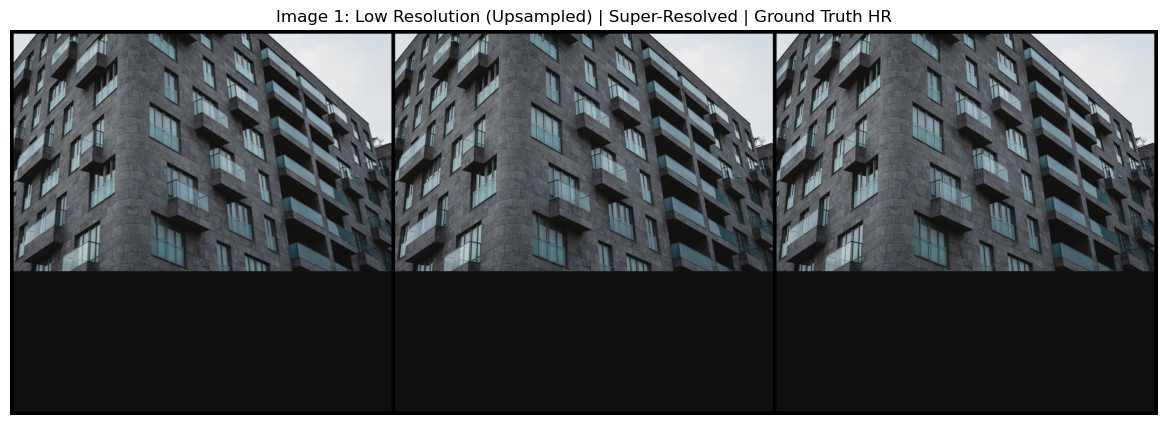

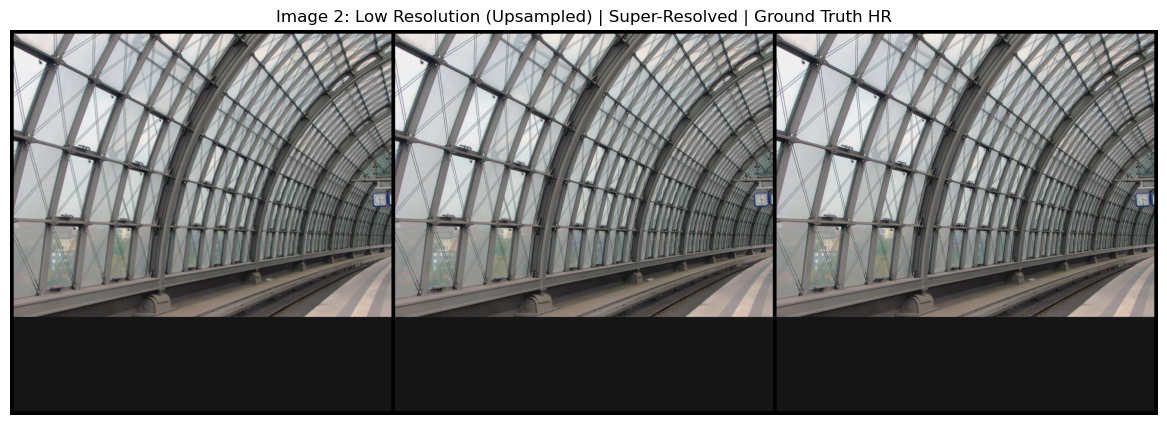

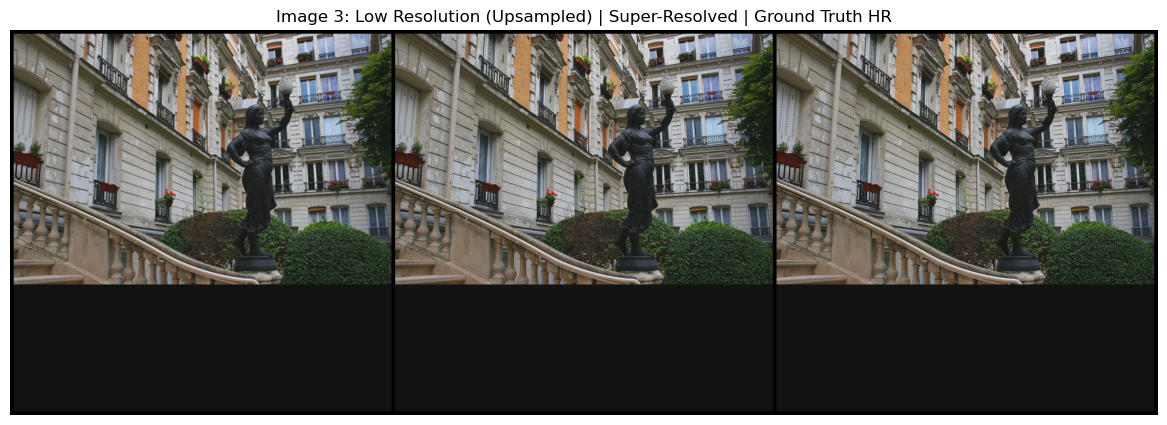

In [ ]:
## Visualize some results: display LR, SR, and HR images side by side
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch.nn.functional as F # Import the functional module for interpolation

# # Set the model to evaluation mode
# # model.eval()
# loaded_model.eval()

# # Move model to the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # model.to(device)
# loaded_model.to(device)

# Select a few images to display (e.g., the first 3 images from the dataset)
num_images_to_show = 3

# Ensure there are enough images to display
if len(set5_lr_images) < num_images_to_show:
    num_images_to_show = len(set5_lr_images)
    print(f"Warning: Only {len(set5_lr_images)} images available. Displaying all available images.")

with torch.no_grad():
    for i in range(num_images_to_show):
        # Get the padded LR and HR images
        lr_input = set5_lr_images[i].unsqueeze(0).to(device) # Add batch dimension and move to device
        hr_ground_truth = set5_hr_images[i].unsqueeze(0).to(device) # Add batch dimension and move to device

        # Generate the super-resolved image
        sr_output = loaded_model(lr_input)

        # Move tensors back to CPU for visualization and remove batch dimension
        lr_input_display = lr_input.squeeze(0).cpu()
        hr_ground_truth_display = hr_ground_truth.squeeze(0).cpu()
        sr_output_display = sr_output.squeeze(0).cpu()

        # Clamp the output to [0, 1] for proper visualization
        sr_output_display = torch.clamp(sr_output_display, 0, 1)

        # Upsample the low-resolution image to match the high-resolution size for visualization
        # Get the size of the high-resolution output
        _, hr_h, hr_w = sr_output_display.shape # Corrected unpacking here
        lr_upsampled_display = F.interpolate(lr_input_display.unsqueeze(0), size=(hr_h, hr_w), mode='bicubic', align_corners=False).squeeze(0)


        # Create a grid of images: LR (upsampled) | SR | HR
        image_grid = vutils.make_grid([lr_upsampled_display, sr_output_display, hr_ground_truth_display], nrow=3, padding=10, normalize=True)

        # Plot the image grid
        plt.figure(figsize=(15, 5))
        plt.imshow(image_grid.permute(1, 2, 0)) # Permute to HWC format for matplotlib
        plt.title(f"Image {i+1}: Low Resolution (Upsampled) | Super-Resolved | Ground Truth HR")
        plt.axis('off')
        plt.savefig(f"./Results/urban100-augmented-high-res-2x-{i+1}.png")  # Save the figure
        plt.show()

In [ ]:
## Calculate FLOPs and Parameters using thop library for input size (1, 3, 720, 1280)
from thop import profile
import torch

# Re-define device to ensure it's in scope
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Create a dummy input tensor for FLOP calculation with the specified size
dummy_input_720p = torch.randn(1, 3, 720, 1280)

# 2. Move this dummy input tensor to the device
dummy_input_720p = dummy_input_720p.to(device)

# 3. Ensure the model is set to evaluation mode and moved to the device
# (This should already be done if the previous evaluation step ran, but good to ensure)
model.eval()
model.to(device)

# 4. Calculate FLOPs (MACs) and parameters using thop.profile
macs_720p, params_720p = profile(model, inputs=(dummy_input_720p,))

# 5. Print the total FLOPs in GigaFLOPs and total parameters in Mega parameters
print(f"FLOPs and Parameters for input size (1, 3, 720, 1280):")
print(f"Total FLOPs (MACs): {macs_720p / 1e9:.2f} G") # Giga FLOPs (MACs is roughly 2*FLOPs)
print(f"Total parameters: {params_720p / 1e6:.2f} M") # Mega parameters

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pixelshuffle.PixelShuffle'>.
FLOPs and Parameters for input size (1, 3, 720, 1280):
Total FLOPs (MACs): 85.39 G
Total parameters: 0.43 M


Parsing 'training.log'...
Successfully parsed 300 data points.
Generating plot...
Plot saved to training_loss_curve_from_log.png


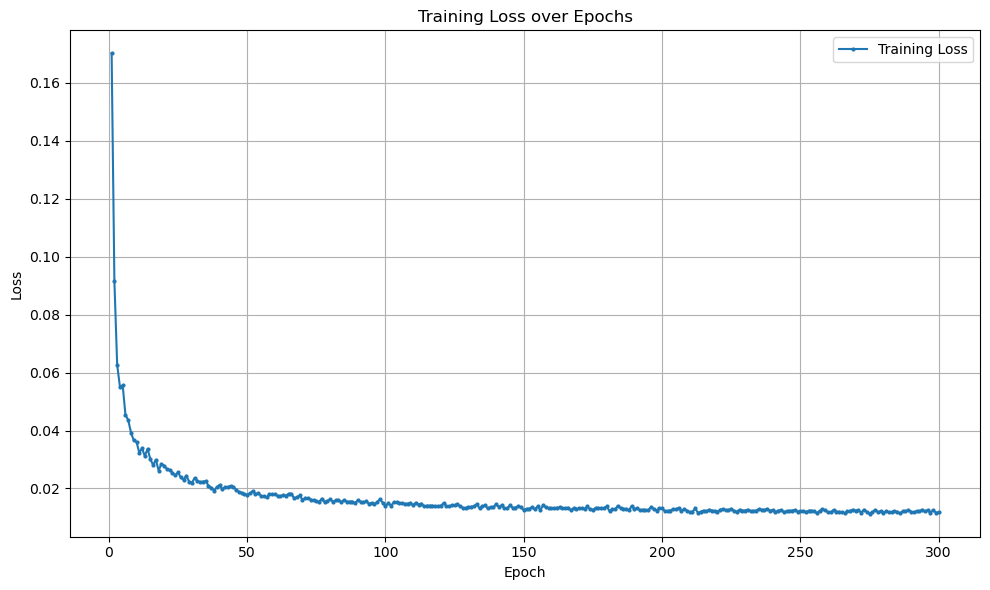

In [ ]:
## Parse training log and plot loss curve as forgot to do this earlier

import matplotlib.pyplot as plt
import re
import numpy as np


# --- 2. Parse the log file ---
print("Parsing 'training.log'...")
epochs = []
losses = []

# This regex captures the epoch number (group 1) and the loss value (group 2)
# It's flexible and ignores the '/300' part
log_pattern = re.compile(r"Epoch (\d+)/\d+, Loss: (\d+\.\d+)")

try:
    with open("./training-log.txt", "r") as f:
        for line in f:
            match = log_pattern.search(line)
            if match:
                # group(1) is the epoch number, group(2) is the loss
                epochs.append(int(match.group(1)))
                losses.append(float(match.group(2)))
    print(f"Successfully parsed {len(epochs)} data points.")

except FileNotFoundError:
    print("Error: 'training.log' not found.")
    # Handle error
    

# --- 3. Plot the results ---
if epochs and losses:
    print("Generating plot...")
    plt.figure(figsize=(10, 6)) # Set a good figure size
    plt.plot(epochs, losses, marker='.', linestyle='-', markersize=4, label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout() # Adjust plot to prevent labels from being cut off
    
    # Save the plot
    plt.savefig('training_loss_curve_from_log.png')
    print("Plot saved to training_loss_curve_from_log.png")
else:
    print("No data was parsed. Cannot generate plot.")

Bar plot saved as 'layer_comparison_barplot.png'


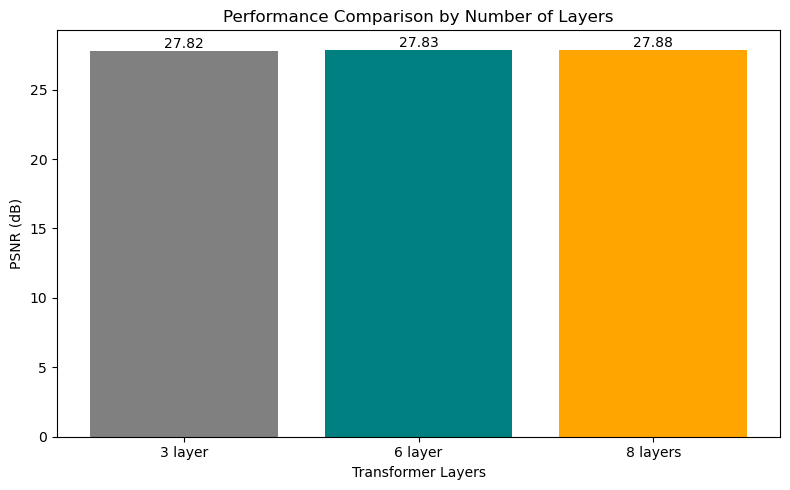

In [ ]:
## Compare PSNR values for different layer depths of EffiecientTransformerBlocks
import matplotlib.pyplot as plt
import pandas as pd

# The dictionary provided by the user
data = {'3 layer': 27.82, '6 layer': 27.8342, '8 layers': 27.88}

# Convert dictionary to a pandas Series for easier plotting and sorting
s = pd.Series(data)
s = s.sort_values()

# Get the keys and values
labels = s.index
values = s.values

# Create the bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=['grey', 'teal', 'orange'])

# Add title and labels
plt.title('Performance Comparison by Number of Layers')
plt.xlabel('Transformer Layers')
plt.ylabel('PSNR (dB)')

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center') 

# Ensure layout is clean
plt.tight_layout()

# Save the plot
# plt.savefig('layer_comparison_barplot.png')

print("Bar plot saved as 'layer_comparison_barplot.png'")